<a href="https://colab.research.google.com/github/joblazek/psp-auction/blob/main/Algorithm1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

  Buyer    Q_i,      P_i
0     0  17.210   23.391
1     1  25.726   66.527
2     2  43.347  151.702
3     3  28.585   38.131
4     4  46.560  158.882
5     5  39.051   98.919
6     6   6.539   20.085
7     7   3.687    5.466
8     8  18.117   29.172
9     9  49.027  158.502
  Buyer  (q_i,  p_i)  a_i  u_i  c_i
0     0    0.0   0.0  0.0  0.0  0.0
1     1    0.0   0.0  0.0  0.0  0.0
2     2    0.0   0.0  0.0  0.0  0.0
3     3    0.0   0.0  0.0  0.0  0.0
4     4    0.0   0.0  0.0  0.0  0.0
5     5    0.0   0.0  0.0  0.0  0.0
6     6    0.0   0.0  0.0  0.0  0.0
7     7    0.0   0.0  0.0  0.0  0.0
8     8    0.0   0.0  0.0  0.0  0.0
9     9    0.0   0.0  0.0  0.0  0.0
Round 1, changes=10
  Buyer   (q_i,   p_i)     a_i       u_i     c_i
0     0  16.997  0.291   0.000     0.000   0.000
1     1  25.651  0.194   0.000     0.000   0.000
2     2  43.314  0.115   0.000     0.000   0.000
3     3  28.367  0.290   0.000     0.000   0.000
4     4  46.471  0.302   0.000     0.000   0.000
5     5  38.886

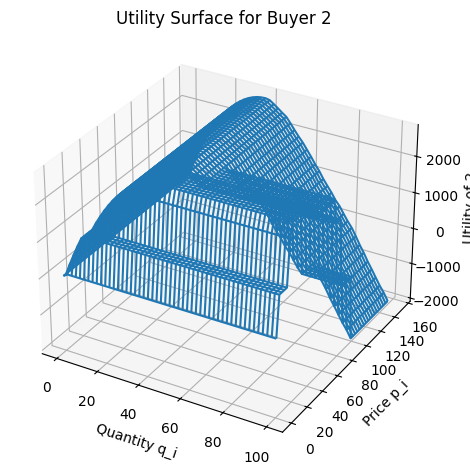

In [91]:
import time
import random
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from typing import Dict, Tuple, List, Optional
from mpl_toolkits.mplot3d import Axes3D

class Seller:
    """Holds bids for a PSP auction."""
    def __init__(self, Q_max: float, epsilon: float):
        self.Q_max = Q_max
        self.s: Dict[str, Tuple[float, float]] = {}
        self.epsilon = epsilon

    def update_bid(self, i: str, s_i: Tuple[float, float]) -> None:
        """Record buyer i's bid (q_i, p_i)."""
        self.s[i] = s_i

    def get_s_hat_minus(self, i: str) -> Dict[str, Tuple[float, float]]:
        """Return bids of all buyers except i."""
        return {j: b for j, b in self.s.items() if j != i}

class Buyer:
    """Implements Algorithm 1: truthful ε-best reply in PSP with exact PSP cost."""
    def __init__(self, i: str, epsilon: float, b_i: float,
                 q_i: float, kappa_i: float,
                 seller: Seller):
        self.i = i
        self.epsilon = epsilon  # convergence threshold
        self.b_i = b_i          # budget constraint
        self.q_i = q_i          # capacity (max quantity)
        self.kappa_i = kappa_i  # valuation intensity
        self.seller = seller
        # initialize bid to zero
        self.s_i: Tuple[float, float] = (0.0, 0.0)
        self.seller.update_bid(self.i, self.s_i)

    def theta_i(self, z: float) -> float:
        """Valuation θ_i(z), θ(z) = κ * q_i * m - (κ/2) * m^2."""
        m = min(z, self.q_i)
        return self.kappa_i * self.q_i * m - 0.5 * self.kappa_i * m**2

    def theta_i_prime(self, z: float) -> float:
        """Marginal valuation θ'_i(z) = κ * (q_i - z) for z ≤ q_i."""
        if z < self.q_i:
            return self.kappa_i * (self.q_i - z)
        else:
            return 0.0

    def Q_i(self, p_i: float, s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """Raw supply Q̄_i(p_i; s_-i)."""
        rem = self.seller.Q_max
        for qj, pj in s_hat_minus.values():
            if pj > p_i:
                rem -= qj
        return max(rem, 0.0)

    def Q_i_bar(self, p_i: float, s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """Supply excluding bids ≥ p_i."""
        rem = self.seller.Q_max
        for qj, pj in s_hat_minus.values():
            if pj >= p_i:
                rem -= qj
        return max(rem, 0.0)

    def P_i(self, z: float, s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """Price density P_i(z; s_-i)."""
        candidates = sorted({0.0} | {pj for (_, pj) in s_hat_minus.values()})
        for y in candidates:
            if self.Q_i(y, s_hat_minus) >= z:
                return y
        return float('inf')

    def integral_P(self, z: float, s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """Compute ∫₀ᶻ P_i(ζ; s_-i) dζ by trapezoidal rule."""
        N = 100
        zs = np.linspace(0, z, N+1)
        Ps = [self.P_i(z_k, s_hat_minus) for z_k in zs]
        dz = z / N if N > 0 else 0
        return sum((Ps[k] + Ps[k+1]) * 0.5 for k in range(N)) * dz

    def a_i(self, s_i: Tuple[float, float], s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """Allocation rule a_i(s) = min(q_i, Q_i_bar(p_i))."""
        q_i, p_i = s_i
        return min(q_i, self.Q_i_bar(p_i, s_hat_minus))

    def c_i(self, s_i: Tuple[float, float], s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """Progressive PSP cost c_i(s) = ∫₀^{a_i} P_i(z)dz."""
        a = self.a_i(s_i, s_hat_minus)
        return self.integral_P(a, s_hat_minus)

    def u_i(self, s_i: Tuple[float, float], s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """Utility u_i(s) = θ_i(a_i) − c_i(s)."""
        a = self.a_i(s_i, s_hat_minus)
        return self.theta_i(a) - self.c_i(s_i, s_hat_minus)

    def sup_G_i(self, s_hat_minus: Dict[str, Tuple[float, float]]) -> float:
        """Exact sup G_i via binary search on [0,q_i]."""
        low, high = 0.0, self.q_i
        for _ in range(20):
            mid = 0.5 * (low + high)
            w = self.theta_i_prime(mid)
            cond1 = (mid <= self.Q_i(w, s_hat_minus))
            cond2 = (self.integral_P(mid, s_hat_minus) <= self.b_i)
            if cond1 and cond2:
                low = mid
            else:
                high = mid
        return low

    def compute_t_i(self, s_hat_minus: Dict[str, Tuple[float, float]]) -> Tuple[float, float]:
        """Compute t_i = (v_i, w_i) per Proposition 1."""
        Gsup = self.sup_G_i(s_hat_minus)
        base = self.theta_i_prime(0.0)             # = κ_i * q_i > 0
        adj  = self.seller.epsilon / base          # use market’s ε
        v    = max(Gsup - adj, 0.0)                # the v_i update
        w    = self.theta_i_prime(v)               # even if v==0, J
        return v, w

    def step(self) -> bool:
        """One Algorithm 1 iteration; return True if s_i updated."""
        s_hat = self.seller.get_s_hat_minus(self.i)
        old = self.s_i
        t = self.compute_t_i(s_hat)
        u_old = self.u_i(old, s_hat)
        u_new = self.u_i(t, s_hat)
        if u_new > u_old + self.seller.epsilon:
            self.s_i = t
            self.seller.update_bid(self.i, t)
            return True
        return False

    def plot_utility_surface(self,
                             s_hat_minus: Dict[str, Tuple[float, float]],
                             q_steps: int = 50,
                             p_steps: int = 50) -> None:
        """
        Plot the 3D utility surface u_i(z, w) over (quantity z, price w).
        """
        zs = np.linspace(0, self.seller.Q_max, q_steps)
        w_max = self.theta_i_prime(0.0)
        ws = np.linspace(0, w_max, p_steps)
        Z, W = np.meshgrid(zs, ws)
        U = np.zeros_like(Z)
        for i in range(p_steps):
            for j in range(q_steps):
                z_val, w_val = Z[i, j], W[i, j]
                U[i, j] = self.u_i((z_val, w_val), s_hat_minus)
        min_u, max_u = U.min(), U.max()
        print(f"Utility range for buyer {self.i}: {min_u:.2f} to {max_u:.2f}")
        fig = plt.figure()
        ax = fig.add_subplot(111, projection='3d')
        ax.plot_wireframe(Z, W, U, rstride=1, cstride=1)
        ax.set_xlabel('Quantity q_i')
        ax.set_ylabel('Price p_i')
        ax.set_zlabel(f'Utility of {self.i}')
        plt.title(f'Utility Surface for Buyer {self.i}')
        plt.tight_layout()
        plt.show()

    def plot_valuation(self, num_points: int = 100) -> None:
        zs = np.linspace(0, self.q_i, num_points)
        vals = [self.theta_i(z) for z in zs]
        plt.plot(zs, vals, label=f'Buyer {self.i}')

# Helper: generate N buyers with random parameters

def init_buyers(num_buyers: int,
                seller: Seller,
                budget_range: Tuple[float, float] = (5.0, 20.0),
                q_range: Tuple[float, float] = (1.0, 50.0),
                kappa_range: Tuple[float, float] = (1.0, 3.5),
                epsilon: float = 0.1) -> List[Buyer]:
    """
    Create `num_buyers` instances with random b_i, q_i, kappa_i,
    uniform over provided ranges, all with the same epsilon.
    """
    buyers: List[Buyer] = []
    for idx in range(num_buyers):
        b_i = random.uniform(*budget_range)
        q_i = random.uniform(*q_range)
        kappa_i = random.uniform(*kappa_range)
        label = f"{idx}"
        buyer = Buyer(label, epsilon, b_i, q_i, kappa_i, seller)
        buyers.append(buyer)
    return buyers

# Helpers: save/load buyer parameters for reproducibility

def save_buyers(buyers: List[Buyer], filepath: str) -> None:
    specs = [
        {"id": b.i, "epsilon": b.epsilon,
         "budget": b.b_i, "capacity": b.q_i,
         "kappa": b.kappa_i}
        for b in buyers
    ]
    pd.DataFrame(specs).to_csv(filepath, index=False)

def load_buyers(filepath: str, seller: Seller) -> List[Buyer]:
    df = pd.read_csv(filepath)
    buyers: List[Buyer] = []
    for _, row in df.iterrows():
        buyer = Buyer(
            row["id"], row["epsilon"], row["budget"],
            row["capacity"], row["kappa"], seller
        )
        buyers.append(buyer)
    return buyers

# Initialization helper

def randbids(buyers: List[Buyer], seller: Seller) -> None:
    """Randomly initialize bids: q_i ~ U[0, q_i], p_i = θ_i'(q_i)."""
    for b in buyers:
        q = random.uniform(1.0, b.q_i)
        p = b.theta_i_prime(q)
        b.s_i = (q, p)
        seller.update_bid(b.i, b.s_i)

# Round printing and simulation

def print_round(buyers: List[Buyer], seller: Seller) -> None:
    df = pd.DataFrame([
        {"Buyer": b.i,
         "(q_i,": b.s_i[0],
         "p_i)": b.s_i[1],
         "a_i": b.a_i(b.s_i, seller.get_s_hat_minus(b.i)),
         "u_i": b.u_i(b.s_i, seller.get_s_hat_minus(b.i)),
         "c_i": b.c_i(b.s_i, seller.get_s_hat_minus(b.i))}
        for b in buyers
    ])
    print(df.round(3))

def print_buyers(buyers: List[Buyer], seller: Seller) -> None:
    df = pd.DataFrame([
        {"Buyer": b.i,
         "Q_i,": b.q_i,
         "P_i": b.theta_i_prime(0.0)}
        for b in buyers
    ])
    print(df.round(3))

# Market totals helper
def market_totals(buyers: List[Buyer], seller: Seller) -> Tuple[float, float, float]:
    """Compute and print total allocation, total valuation, and total utility of the market."""
    total_alloc = 0.0
    total_value = 0.0
    total_utility = 0.0
    for b in buyers:
        s_hat = seller.get_s_hat_minus(b.i)
        a = b.a_i(b.s_i, s_hat)
        total_alloc += a
        total_value += b.theta_i(a)
        total_utility += b.u_i(b.s_i, s_hat)
    print(f"Market Totals -> TotalAlloc: {total_alloc:.2f}, TotalValue: {total_value:.2f}, TotalUtility: {total_utility:.2f}")


def run_simulation(buyers: List[Buyer], seller: Seller,
                   max_rounds: int = 100, delay: float = 0.5) -> None:
    for r in range(1, max_rounds+1):
        changes = sum(b.step() for b in buyers)
        print(f"Round {r}, changes={changes}")
        print_round(buyers, seller)
        market_totals(buyers, seller)
        if changes == 0:
            print("Converged")
            break
        time.sleep(delay)

if __name__ == "__main__":
    seller = Seller(Q_max=100.0, epsilon=5.0)
    buyers = init_buyers(10, seller)

    # Optional: save parameters
    save_buyers(buyers, "buyers.csv")

    # Random initialization of bids
    #randbids(buyers, seller)
    print_buyers(buyers, seller)
    print_round(buyers, seller)

    # Plot valuations
    """
    plt.figure()
    for b in buyers:
        b.plot_valuation()
        plt.legend()
        plt.xlabel("Quantity z")
        plt.ylabel("Valuation θ_i(z)")
    """

    # Run PSP auction
    run_simulation(buyers, seller, max_rounds=200, delay=0.2)

    # Plot utility surface (with s_-i)
    buyers[2].plot_utility_surface(seller.get_s_hat_minus(buyers[2].i))
